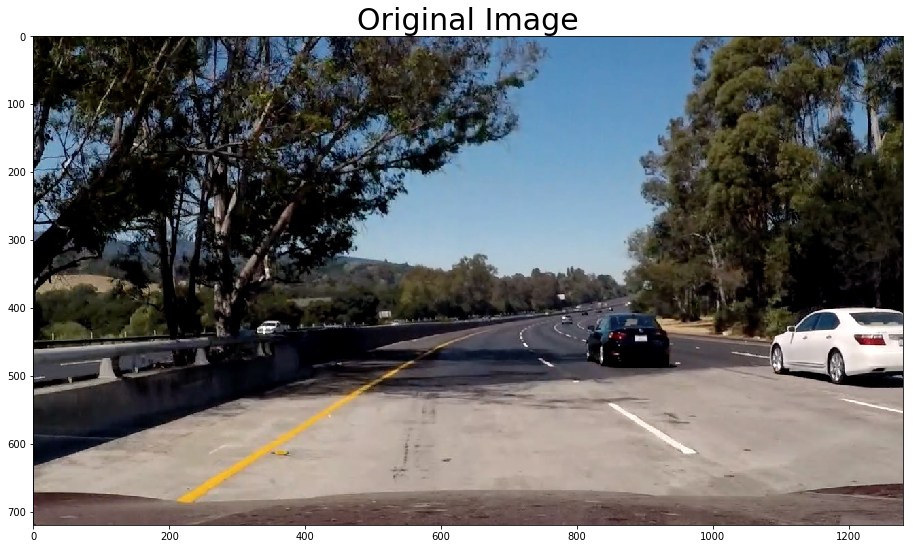

In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


serialize = pickle.load( open( "calibrate_matrix.pickle", "rb" ) )
mtx = serialize["mtx"]
dist = serialize["dist"]

# Check for calibration
# Compare the images post undistort
img_BGR = cv2.imread('test_images/test5.jpg')
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

# Show Single Image
def show_img(img, title, isGray=False, patch = None):
    f, ax = plt.subplots(1, 1, figsize=(24, 9))
    # Check if gray scale
    if isGray:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    # Check if patch is there
    if patch is not None:
        ax.add_patch(rect)
    plt.title(title, fontsize=30)

show_img(img_RGB, 'Original Image')

Text(0.5,1,'Gray')

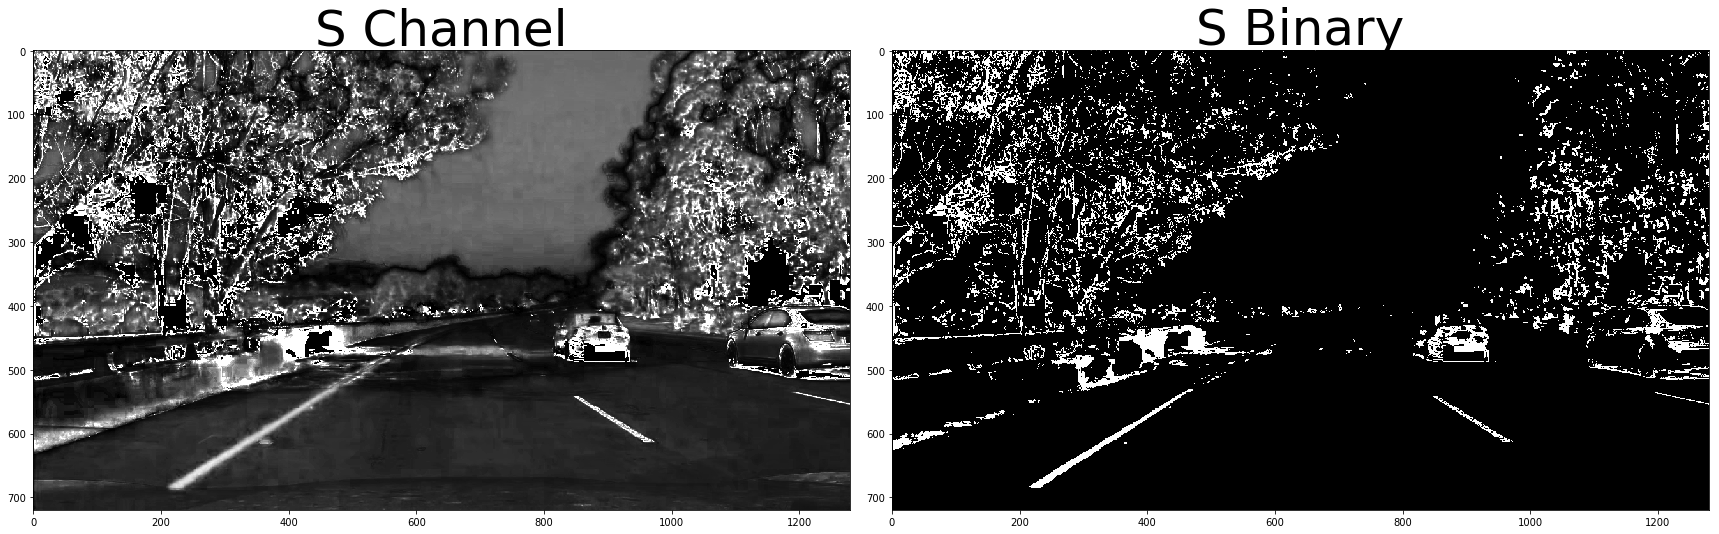

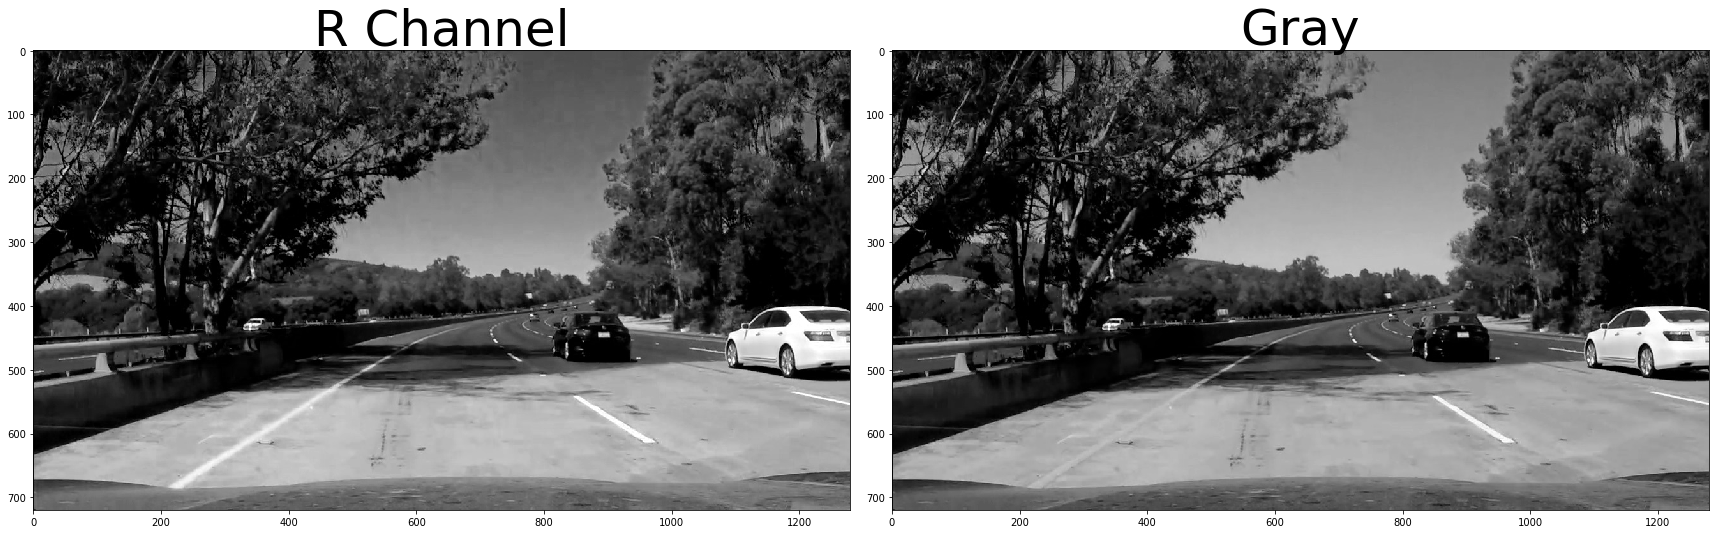

In [2]:
# Perform color threshold
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary

hls = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HLS)
S = hls[:,:,2]

hls_binary = hls_select(img_BGR, thresh=(170, 255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(S, cmap='gray')
ax1.set_title('S Channel', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('S Binary', fontsize=50)

R = img_RGB[:,:,0]

f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f2.tight_layout()
ax3.imshow(R, cmap='gray')
ax3.set_title('R Channel', fontsize=50)
ax4.imshow(cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY), cmap='gray')
ax4.set_title('Gray', fontsize=50)

In [3]:
# Define all the Sobel functions

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale (RGB to grayscale)
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobelxy = np.sqrt(np.square(sobelx)+ np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
       # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    #sobelxy = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    sobelxy = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(sobelxy)
    sxbinary[(sobelxy >= thresh[0]) & (sobelxy <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

Text(0.5,1,'Mag Gray')

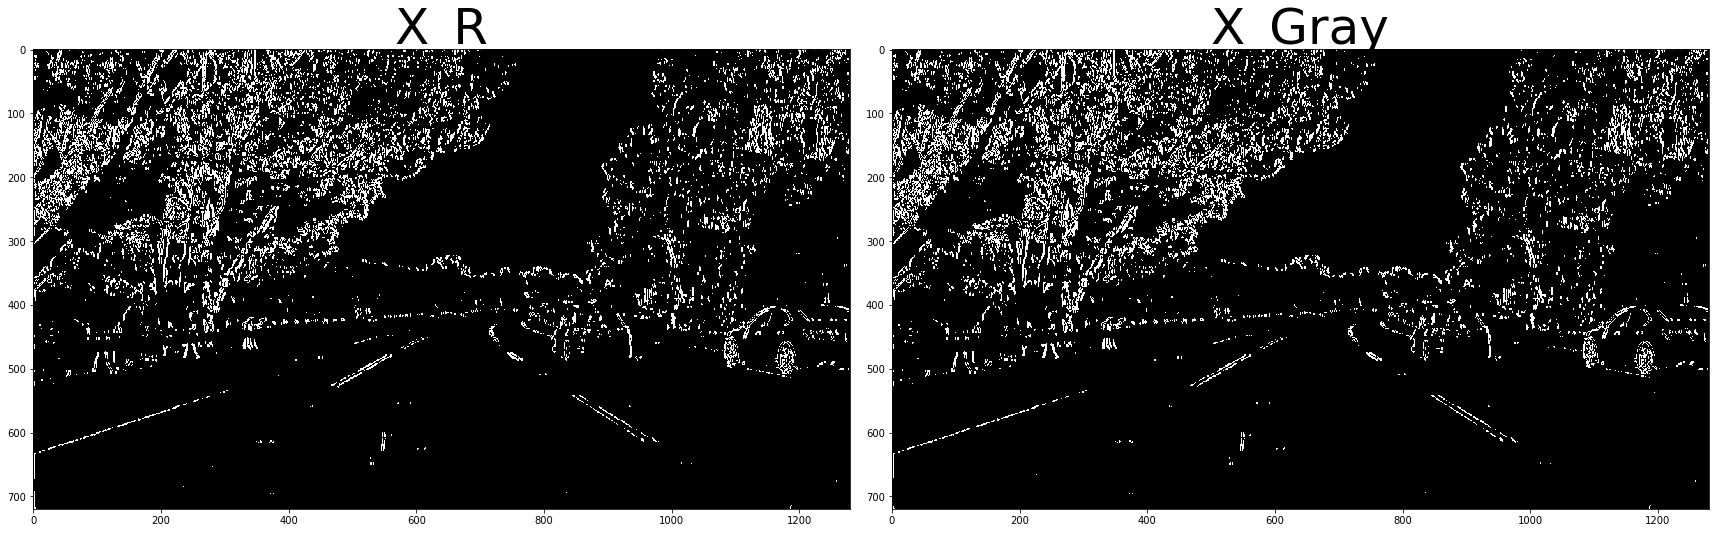

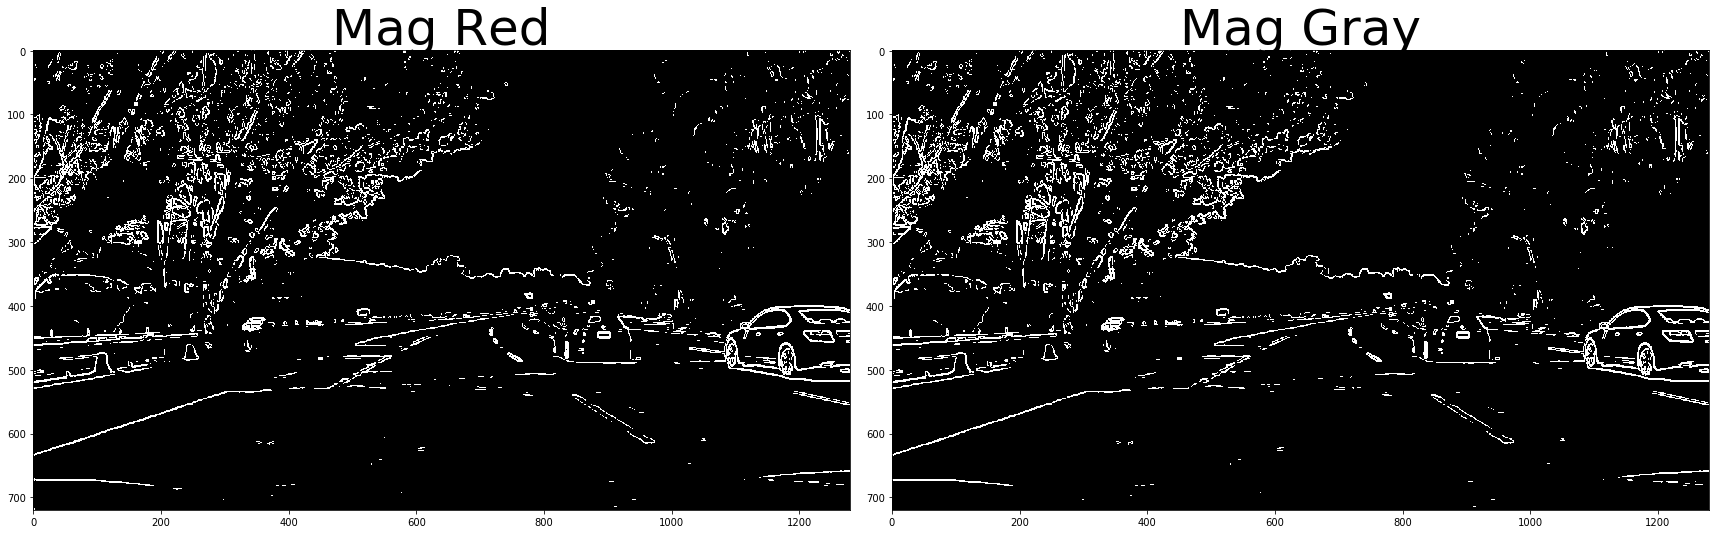

In [4]:
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(R, orient='x', sobel_kernel=ksize, thresh=(30, 100))
# grady = abs_sobel_thresh(R, orient='y', sobel_kernel=ksize, thresh=(10, 200))
gradx_gray = abs_sobel_thresh(cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY), orient='x', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(R, sobel_kernel=ksize, mag_thresh=(55, 255))
mag_binary_gray = mag_thresh(cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY), sobel_kernel=ksize, mag_thresh=(55, 255))
#dir_binary = dir_threshold(R, sobel_kernel=ksize, thresh=(.7, 1.3))

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('X_R', fontsize=50)
ax2.imshow(gradx_gray, cmap='gray')
ax2.set_title('X_Gray', fontsize=50)

f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f2.tight_layout()
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Mag Red', fontsize=50)
ax4.imshow(mag_binary_gray, cmap='gray') # similar in performance to R channel
ax4.set_title('Mag Gray', fontsize=50) 
#ax4.set_title('Dir', fontsize=50) - Lot of noise

Text(0.5,1,'Combined')

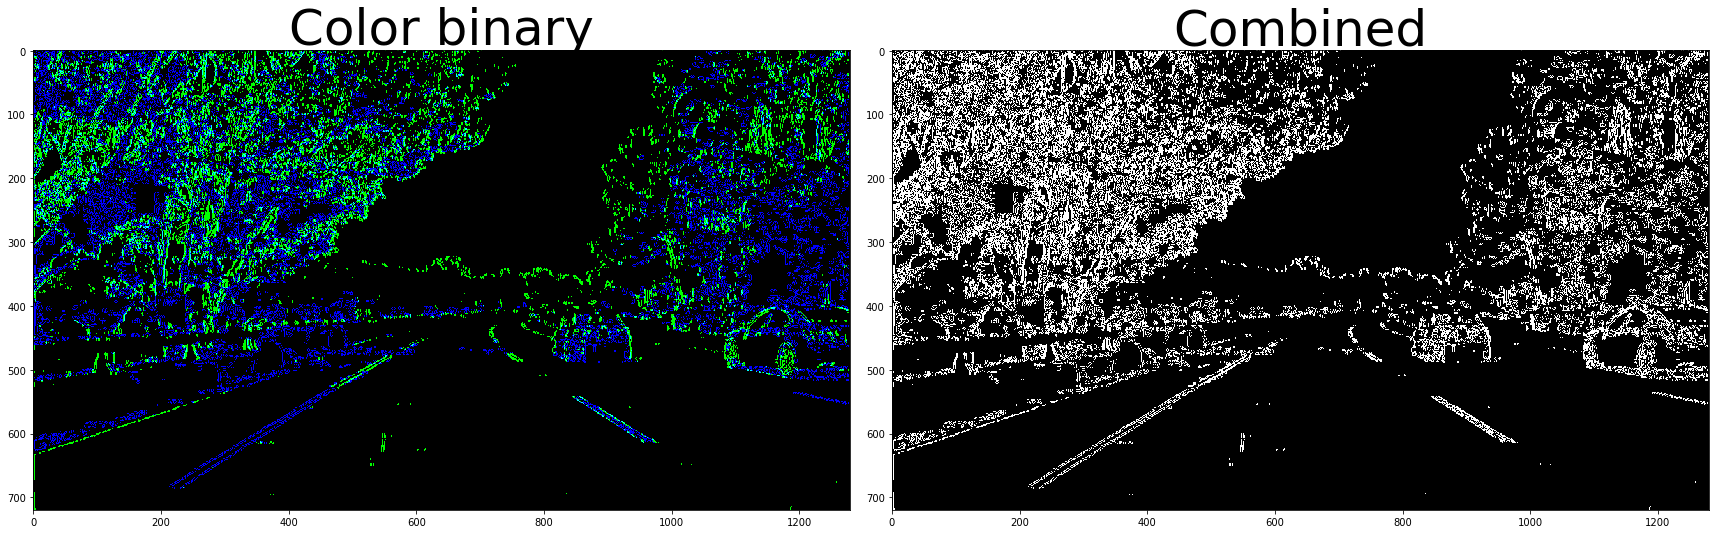

In [139]:
# Thresholding function based on work above
def combined_threshold(img_RGB):
    # Get R Channel
    R = img_RGB[:,:,0]
    gradx = abs_sobel_thresh(R, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    
    # Compute the HLS Threshold
    img_BGR = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2BGR)
    # Option 1 - Just S threshold
    hls_binary = hls_select(img_BGR, thresh=(170, 255))
    # Option 2 - Sobel X on S binary threshold channel
    hls = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    hls_binary = abs_sobel_thresh(hls_binary, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    
    #Combine
    combined = np.zeros_like(gradx)
    # Color stack
    color_binary = np.dstack(( np.zeros_like(gradx), gradx, hls_binary)) * 255
    # Combined 
    combined[((hls_binary == 1) | (gradx == 1))] = 1
    
    return color_binary, combined
    

color_binary, combined = combined_threshold(img_RGB)    

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary)
ax1.set_title('Color binary', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)

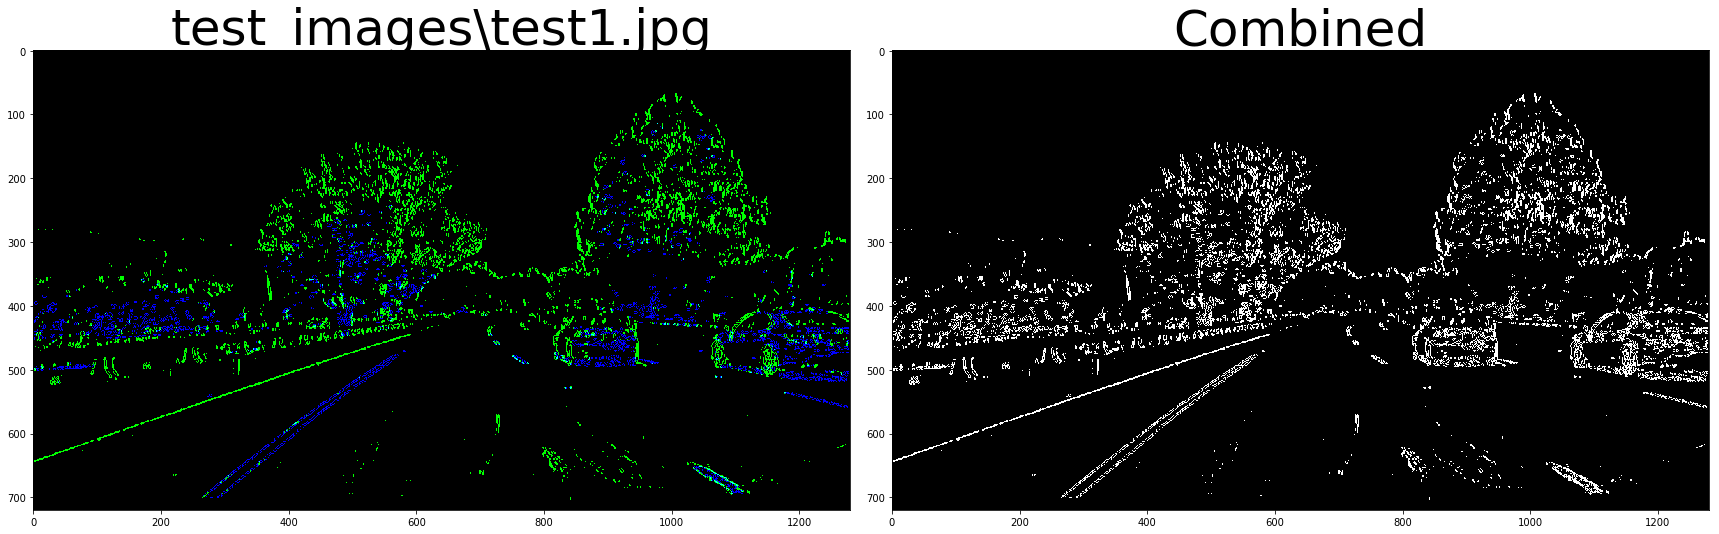

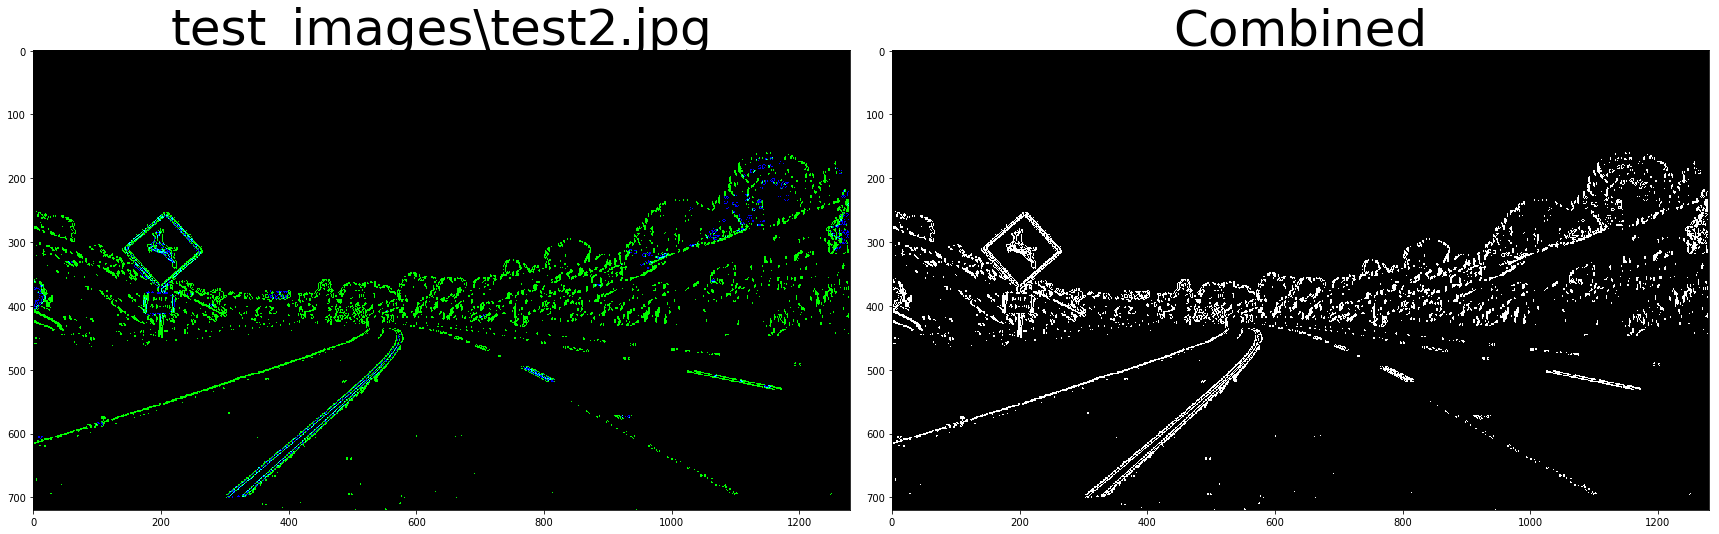

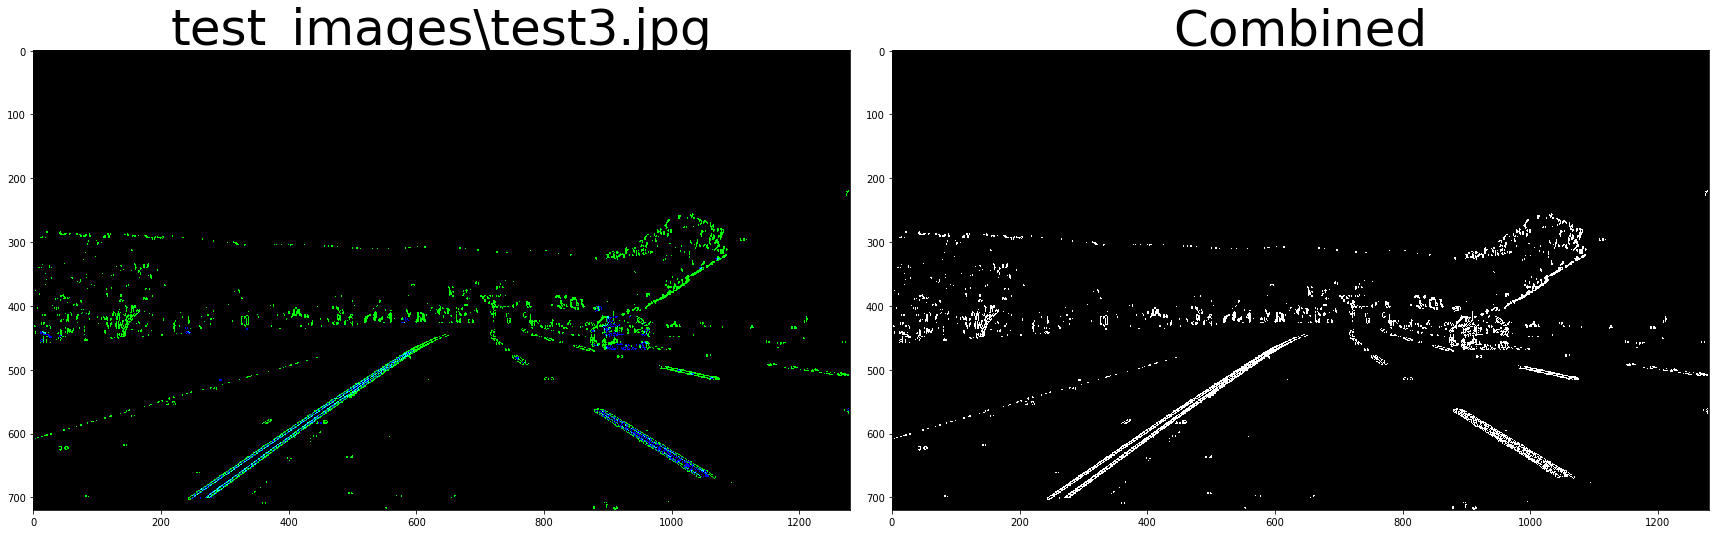

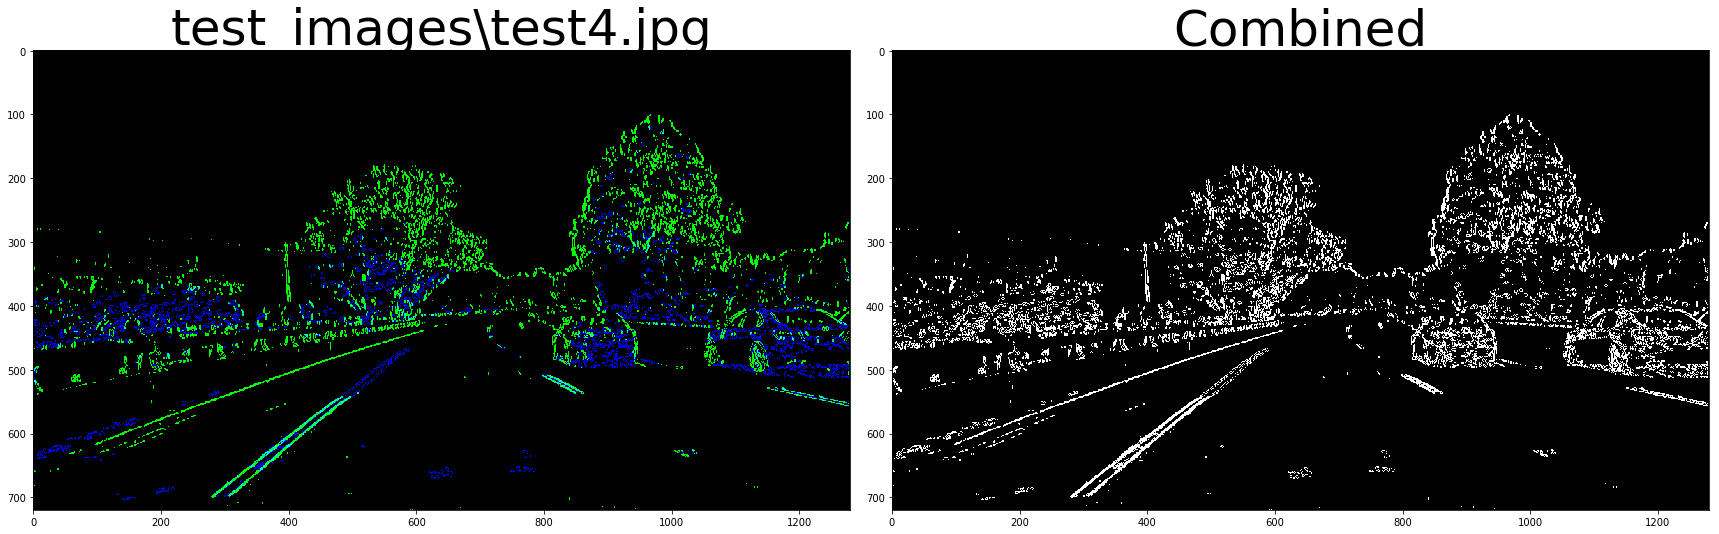

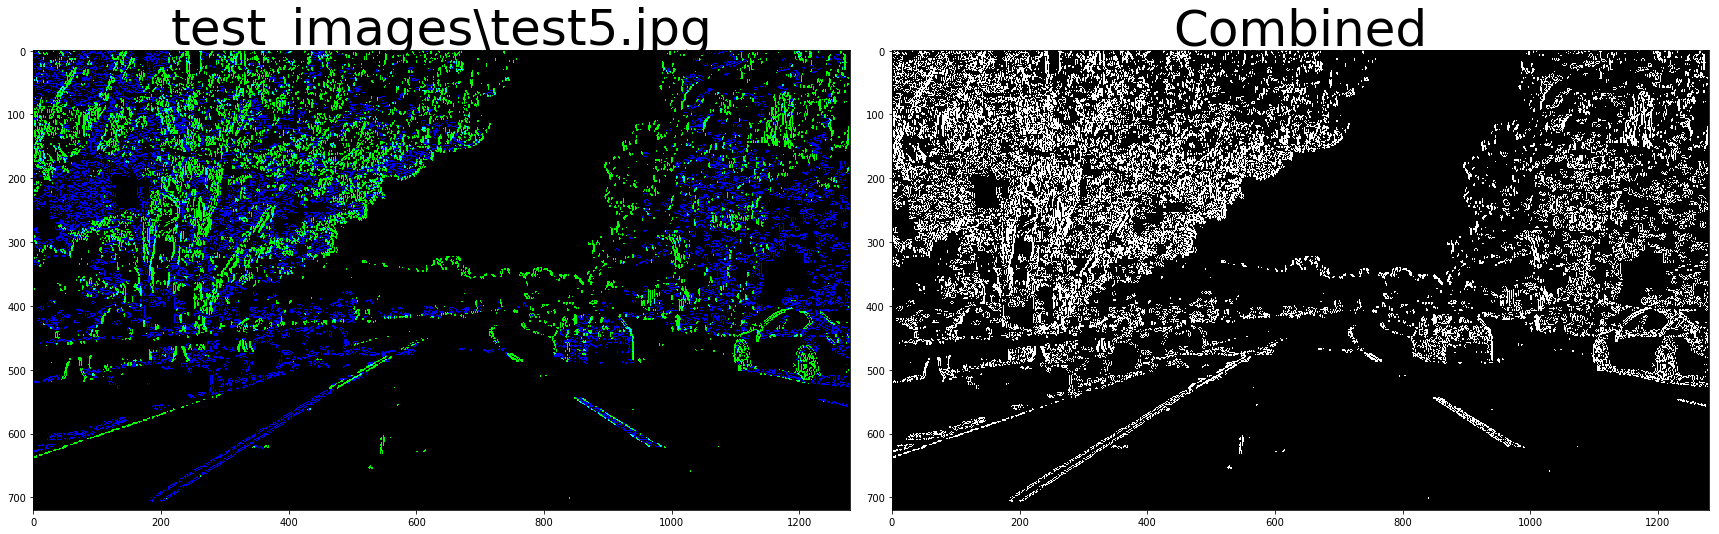

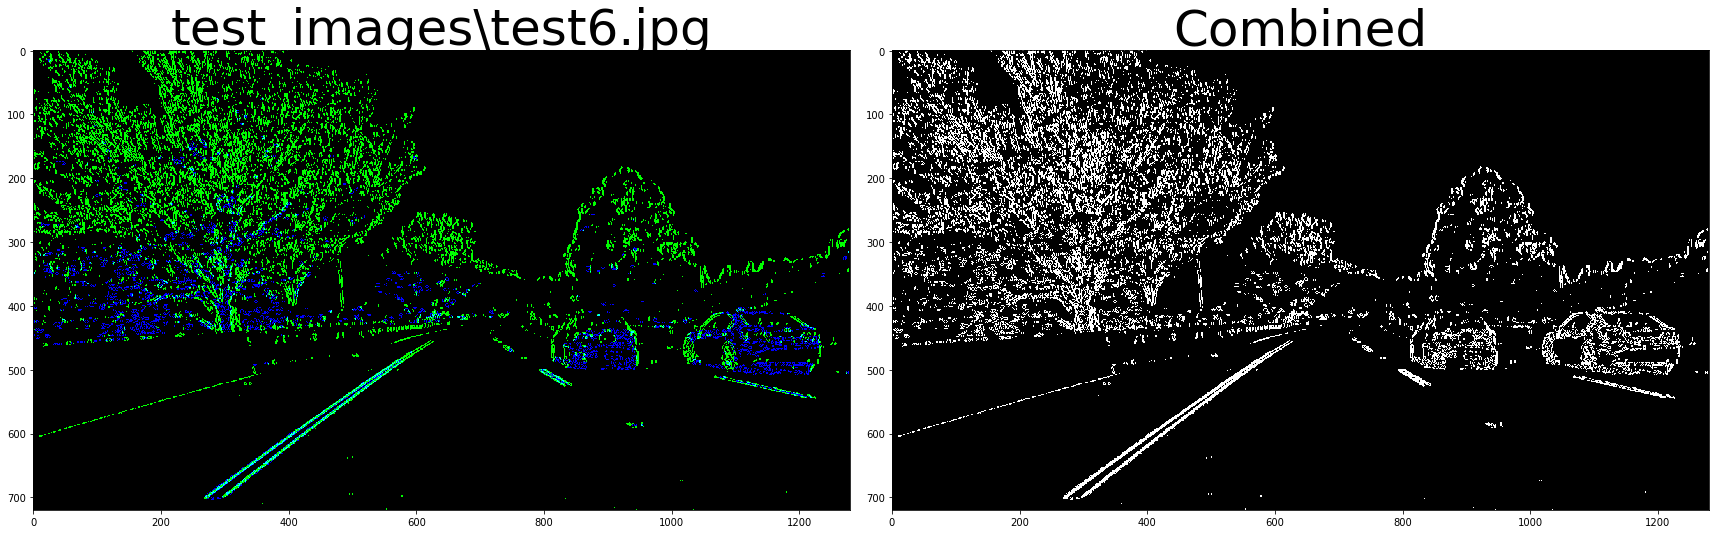

In [140]:
# Try for all test images
import glob
images = glob.glob('test_images/test*.jpg')

for image in images:
    img = undistort(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))
    color_binary, combined = combined_threshold(img)  
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(color_binary)
    ax1.set_title(image, fontsize=50)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Combined', fontsize=50)
    

In [141]:
# Perspective Transform using straight lines
import matplotlib.patches as patches
    
img_st_BGR = cv2.imread('test_images/straight_lines1.jpg')
img_st_RGB = cv2.cvtColor(img_st_BGR, cv2.COLOR_BGR2RGB)

# Undistort image 
def undistort(img):    
    return cv2.undistort(img, mtx, dist, None, mtx)
    
# Create birds eye view from undistorted image
def birds_perspective(img, SPEED = 0):
    
    # Define source points
    src = np.zeros((4, 2), dtype=np.float32)
    
    if SPEED == 0: # High speed - longer view
        # Long
        src[0] = [610,440]
        src[1] = [670,440]
        src[2] = [1130,720]
        src[3] = [190,720]
    elif SPEED == 1:
        # Medium
        src[0] = [580,460]
        src[1] = [705,460]
        src[2] = [1130,720]
        src[3] = [190,720]
    elif SPEED == 2:      
        #Short
        src[0] = [525,500]
        src[1] = [770,500]
        src[2] = [1130,720]
        src[3] = [190,720]
    
    # Destination Points
    dst = np.zeros((4, 2), dtype=np.float32)
    width = img.shape[1]
    height = img.shape[0]
    offset = 250 # offset for dst points
    dst[0] = (offset, 0)
    dst[1] = (width-offset, 0)
    dst[2] = (width-offset, height)
    dst[3] = (offset, height)
    
    M = cv2.getPerspectiveTransform(src, dst)
    dest_img = cv2.warpPerspective(img, M, (width, height),flags=cv2.INTER_LINEAR)
    
    return src, dst, M, dest_img



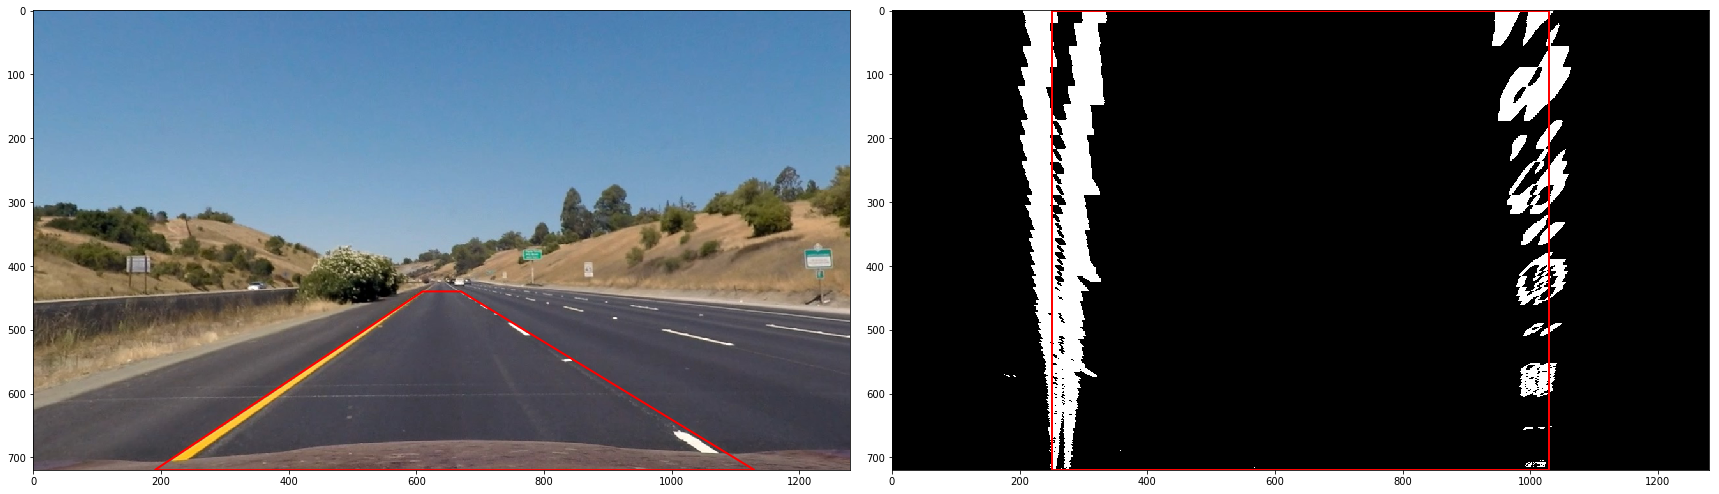

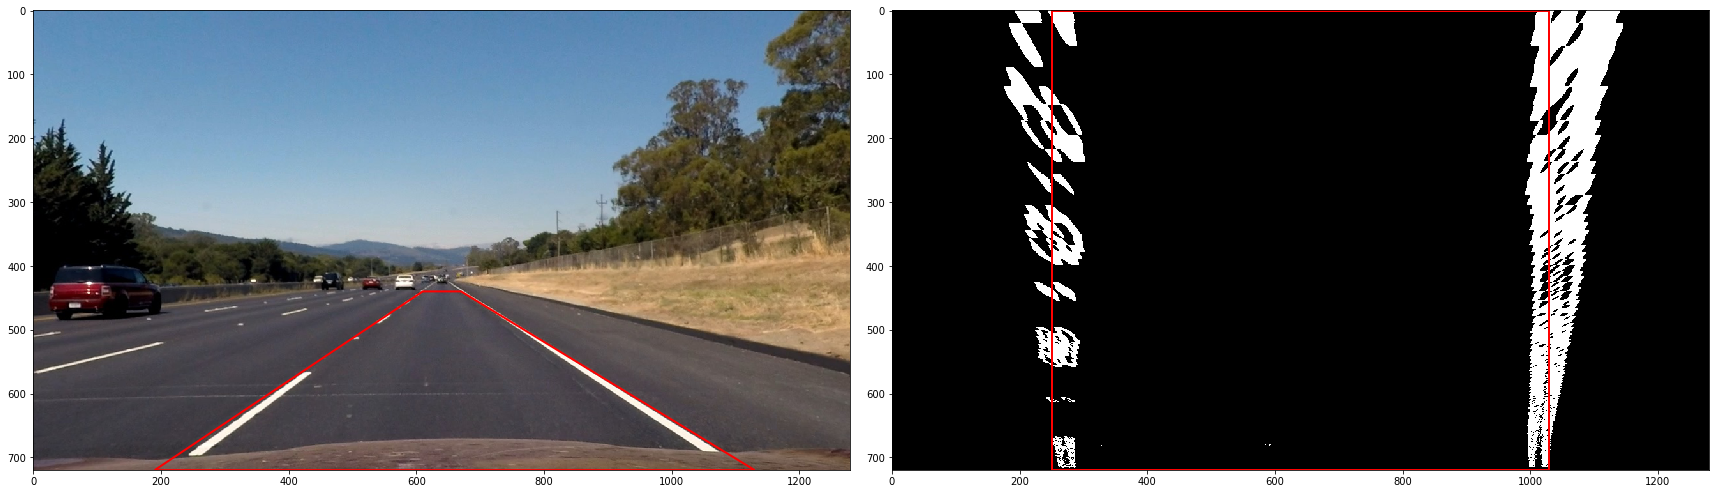

In [148]:
# Check long term lines
st_images = glob.glob('test_images/straight_lines*.jpg')
# Validate the perspective transform source for straight lines
for image in st_images:
    img = undistort(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))
    color_binary, combined = combined_threshold(img)
    src, dst, M, birds_eyeL = birds_perspective(combined, 0)
    
    srcL = patches.Polygon( src, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    dstL = patches.Polygon( dst, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    f, (ax1, ax4) = plt.subplots(1,2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.add_patch(srcL)
    ax4.imshow(birds_eyeL, cmap='gray')
    ax4.add_patch(dstL)

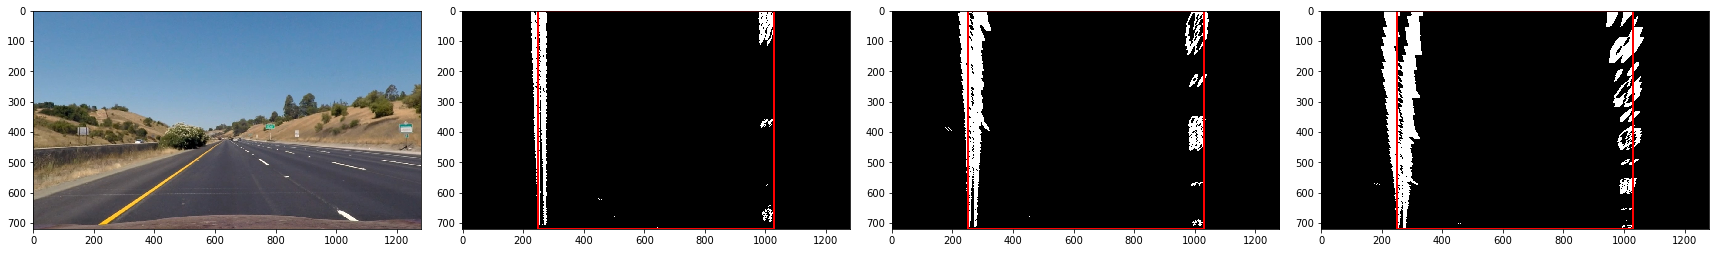

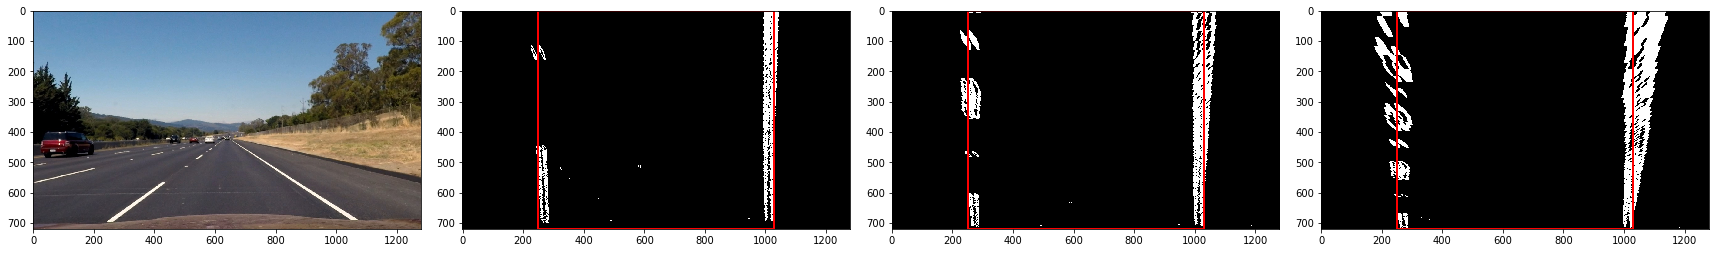

In [149]:
st_images = glob.glob('test_images/straight_lines*.jpg')
# Validate the perspective transform source for straight lines
for image in st_images:
    img = undistort(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))
    color_binary, combined = combined_threshold(img)
    src, dstL, M, birds_eyeL = birds_perspective(combined, 0)
    src, dstM, M, birds_eyeM = birds_perspective(combined, 1)
    src, dstS, M, birds_eyeS = birds_perspective(combined, 2)
    
    rectL = patches.Polygon( dstL, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    rectM = patches.Polygon( dstM, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    rectS = patches.Polygon( dstS, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax2.imshow(birds_eyeS, cmap='gray')
    ax2.add_patch(rectS)
    ax3.imshow(birds_eyeM, cmap='gray')
    ax3.add_patch(rectM)
    ax4.imshow(birds_eyeL, cmap='gray')
    ax4.add_patch(rectL)
    

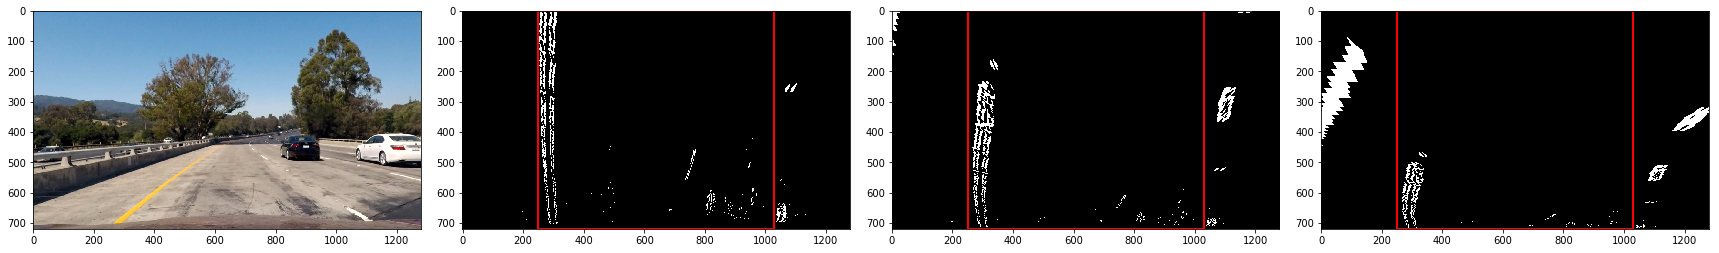

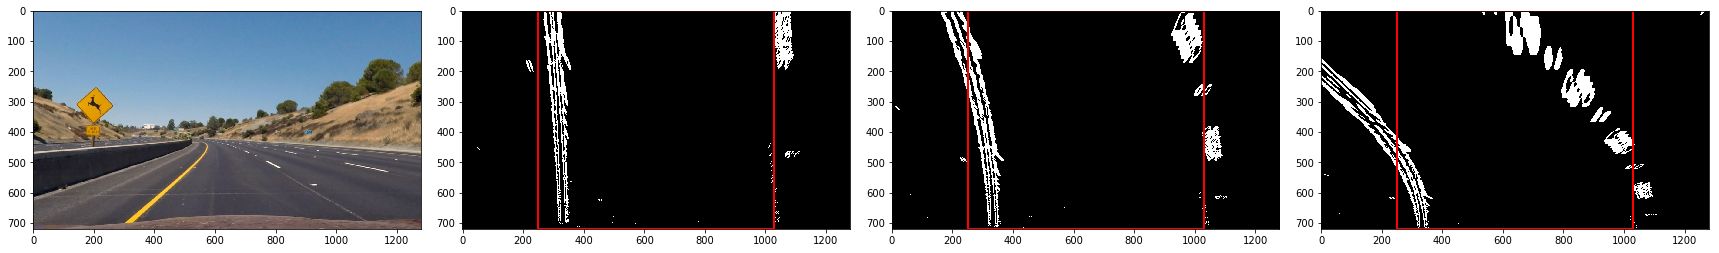

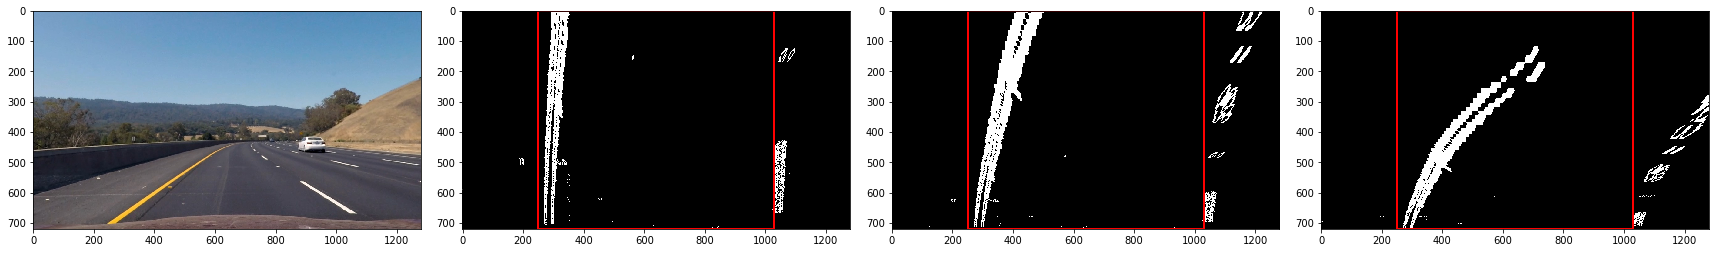

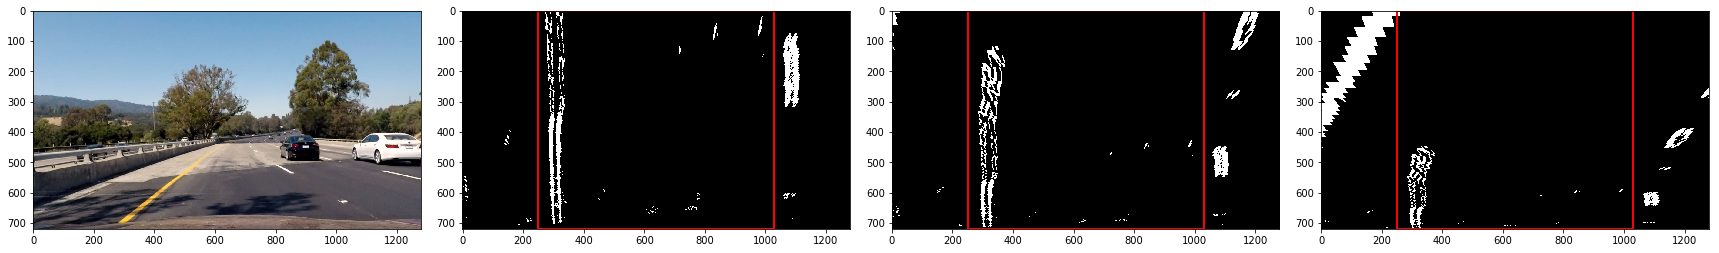

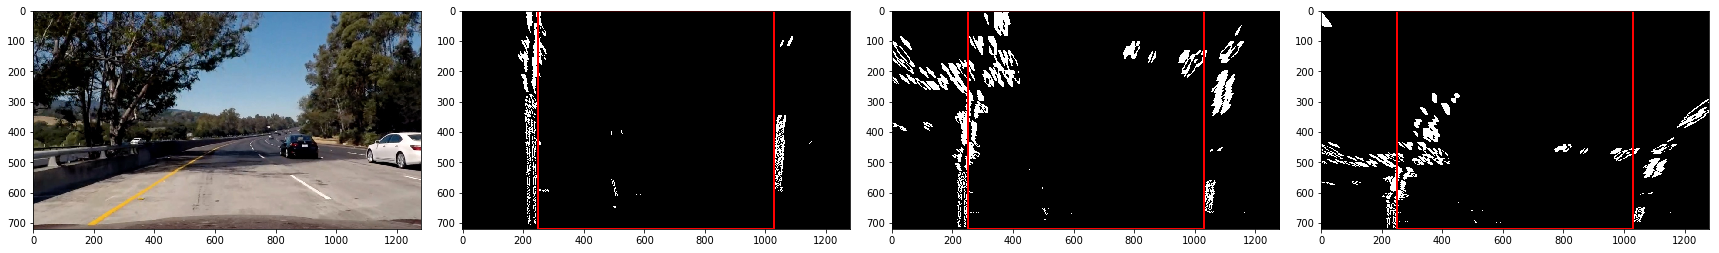

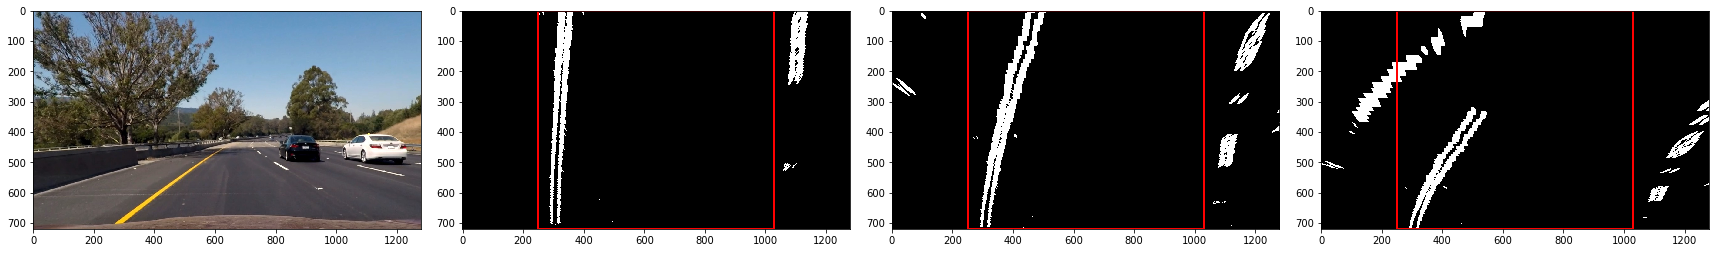

In [150]:
# Validate the transform source for curved lines
images = glob.glob('test_images/test*.jpg')
# Validate the perspective transform source for curved test lines for different views
for image in images:
    img = undistort(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))
    color_binary, combined = combined_threshold(img)
    src, dstL, M, birds_eyeL = birds_perspective(combined, 0)
    src, dstM, M, birds_eyeM = birds_perspective(combined, 1)
    src, dstS, M, birds_eyeS = birds_perspective(combined, 2)
    
    rectL = patches.Polygon( dstL, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    rectM = patches.Polygon( dstM, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    rectS = patches.Polygon( dstS, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax2.imshow(birds_eyeS, cmap='gray')
    ax2.add_patch(rectS)
    ax3.imshow(birds_eyeM, cmap='gray')
    ax3.add_patch(rectM)
    ax4.imshow(birds_eyeL, cmap='gray')
    ax4.add_patch(rectL)
    
